# EDA using HeatMaps
This notebook explores the GDP and CO2 emissions datasets contained in `..\data\final`.

## Step 0: Import and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')
df_top40 = pd.read_csv('../data/final/gdp_co2_emissions_top40_2024.csv')

 ---

## Step 1: Data Preparation
Quick inspection

In [3]:
df.head()

,Country Name,Country Code,Continent,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,Afghanistan,AFG,Asia,2000,1047127.94,0.052017,6.206548e+09,1617.826475,NaN
1,Afghanistan,AFG,Asia,2001,1069098.00,0.052706,5.621148e+09,1454.110782,-9.431974
2,Afghanistan,AFG,Asia,2002,1341065.00,0.062731,7.228796e+09,1774.308743,28.600001
3,Afghanistan,AFG,Asia,2003,1559679.00,0.068608,7.867263e+09,1815.928200,8.832278
4,Afghanistan,AFG,Asia,2004,1237247.00,0.052513,7.978516e+09,1776.918207,1.414118


In [4]:
df_top40.head()

,Country Name,Country Code,Continent,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,United States,USA,North America,2024,4.904120e+09,14.197287,2.256846e+13,75489.266433,2.793001
1,China,CHN,Asia,2024,1.228904e+10,8.658390,1.848811e+13,23845.619722,4.977357
2,Japan,JPN,Asia,2024,9.618673e+08,7.772474,4.606003e+12,46106.922923,0.104309
3,Germany,DEU,Europe,2024,5.723192e+08,6.768824,3.677049e+12,62554.554723,-0.495852
4,India,IND,Asia,2024,3.193478e+09,2.200978,3.477821e+12,9818.042707,6.494766


 ---
## Step 3: Feature Understanding
Plotting **Heatmap correlations** between GDP and CO2 emissions. The heatmap allows to visualize how each variable interact. 

We can see that Total GDP is always a good predictor of Total CO2 emissions.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Columns for correlation
numeric_cols = ['Total CO2 emissions', 'CO2 emissions per capita', 
                'GDP', 'GDP per capita', 'GDP growth (annual %)']

### 3.1 Correlation Heatmap all countries


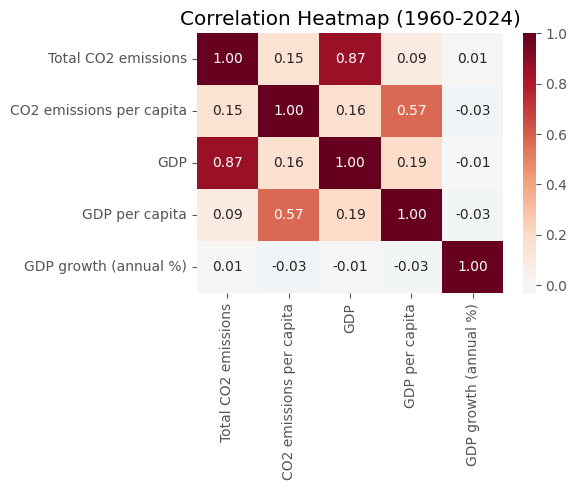

In [6]:
min_year = df['Year'].min()
max_year = df['Year'].max()

plt.figure(figsize=(6, 5))
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title(f'Correlation Heatmap ({min_year}-{max_year})')
plt.tight_layout()
plt.savefig('../outputs/plots/heatmaps/correlation_heatmap_gdp_co2.png', dpi=300, bbox_inches='tight')
plt.show()

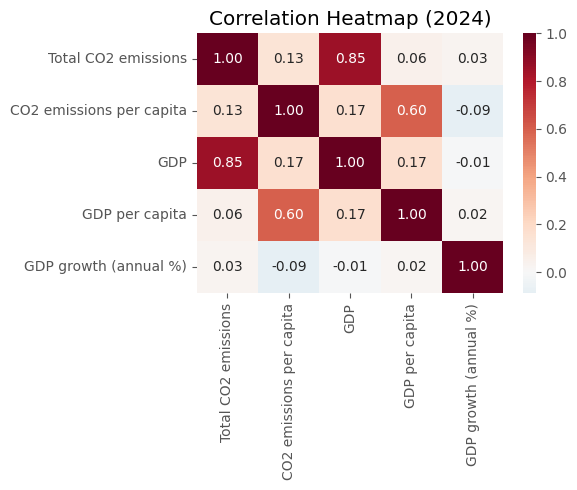

In [7]:
plt.figure(figsize=(6, 5))
df_2024 = df[df['Year'] == 2024]
correlation_matrix = df_2024[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title('Correlation Heatmap (2024)')
plt.tight_layout()
plt.savefig('../outputs/plots/heatmaps/correlation_heatmap_gdp_co2_2024.png', dpi=300, bbox_inches='tight')
plt.show()

As expected, there is strong evidence (0.87 correlation) that the Total `GDP` and `Total CO2 emissions` are related, whereas, interestingly, `GDP per capita` and `CO2 per capita` correlation is more moderate (0.57 correlation). This means that individual wealth doesn't necessary lead to higher pollution, suggesting that technological or energetic differences between countries also play an important role.

It can also be seen that the annual growth of a country is not a good predictor for CO2 emissions (approx 0 correlation), therefore the _rate_ at which an economy grows in a single year doesn't have a significative environmental impact.

### 3.2 Correlation Heatmap top-40 countries (2024)

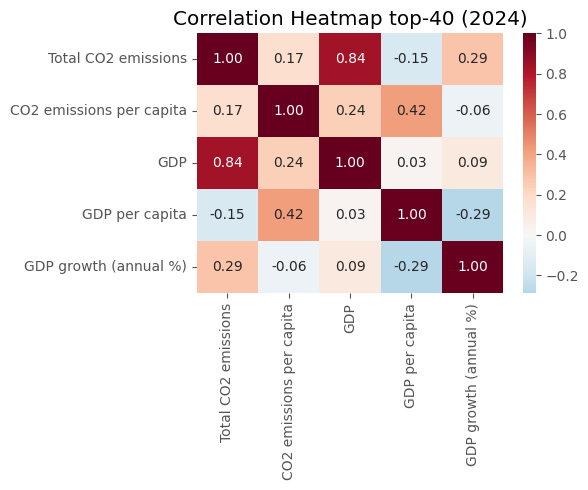

In [8]:
plt.figure(figsize=(6, 5))
correlation_matrix = df_top40[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title('Correlation Heatmap top-40 (2024)')
plt.tight_layout()
plt.savefig('../outputs/plots/heatmaps/correlation_heatmap_gdp_co2_top40_2024.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Correlation Heatmaps across all continents

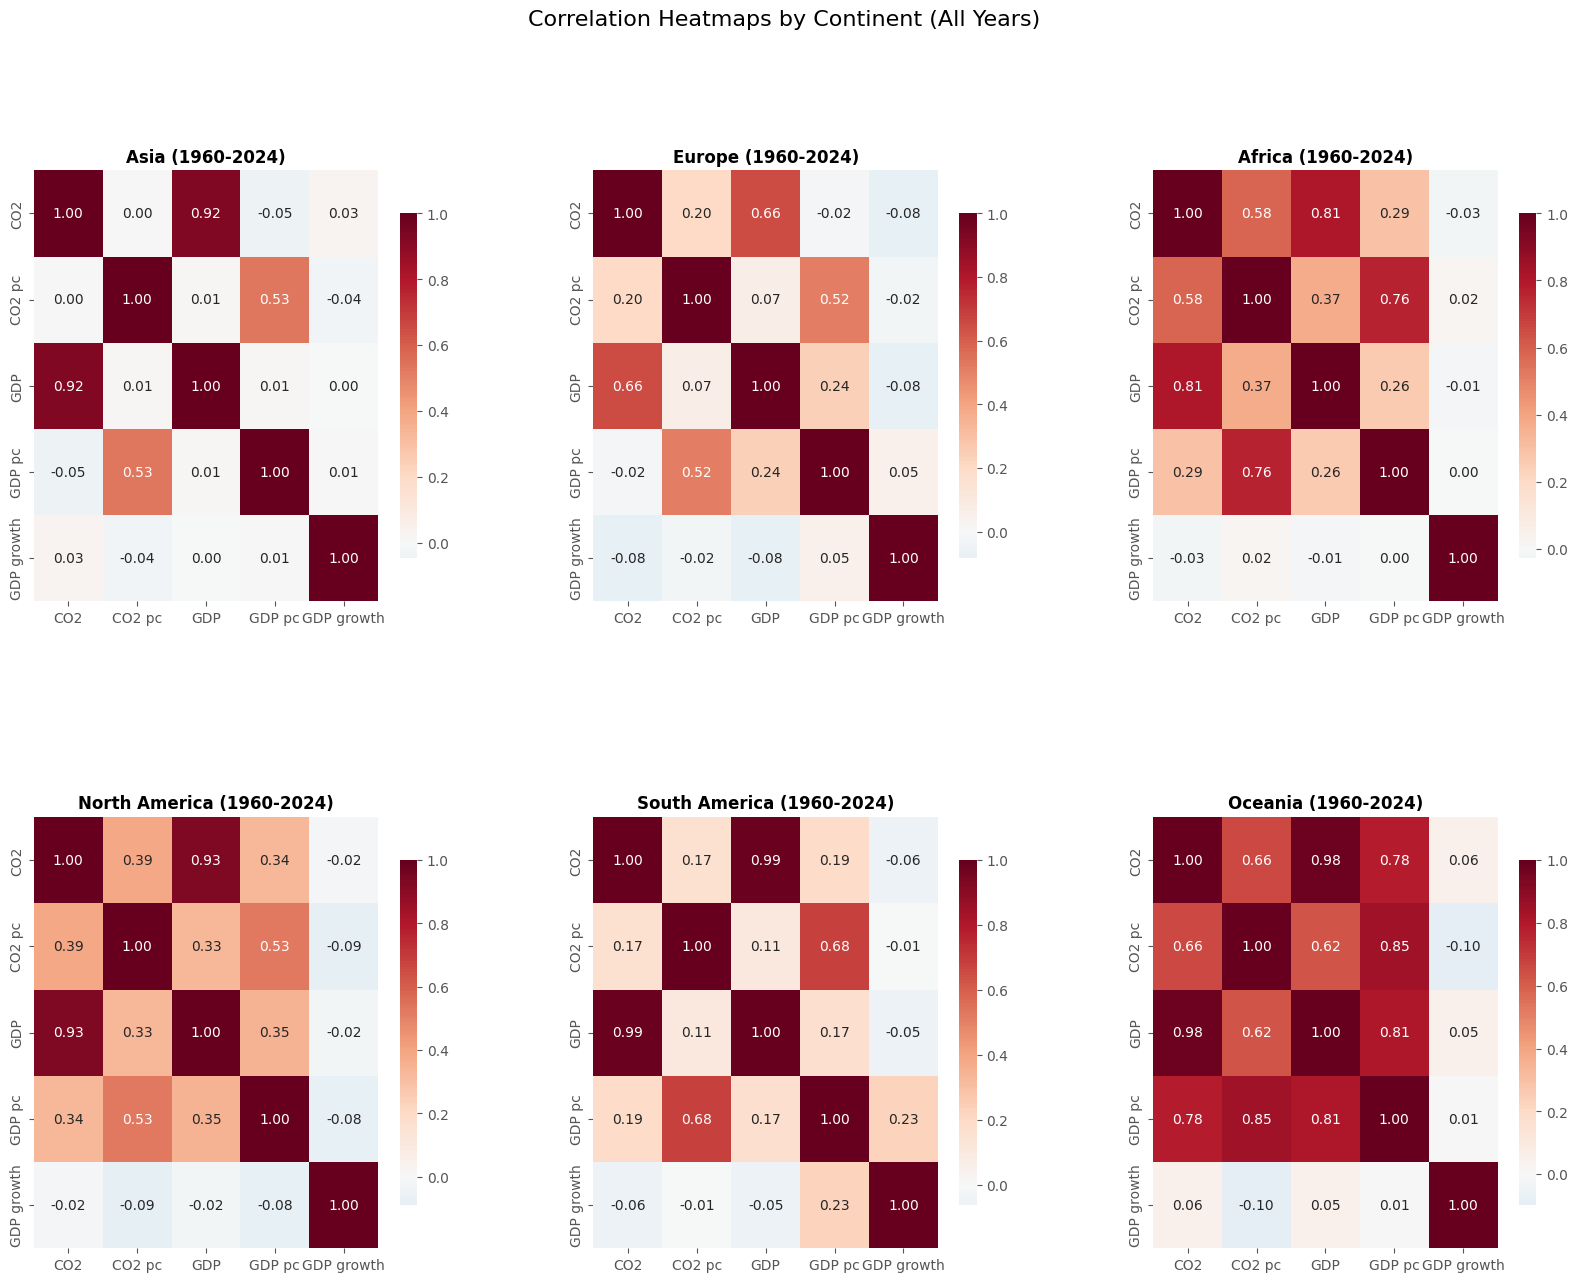

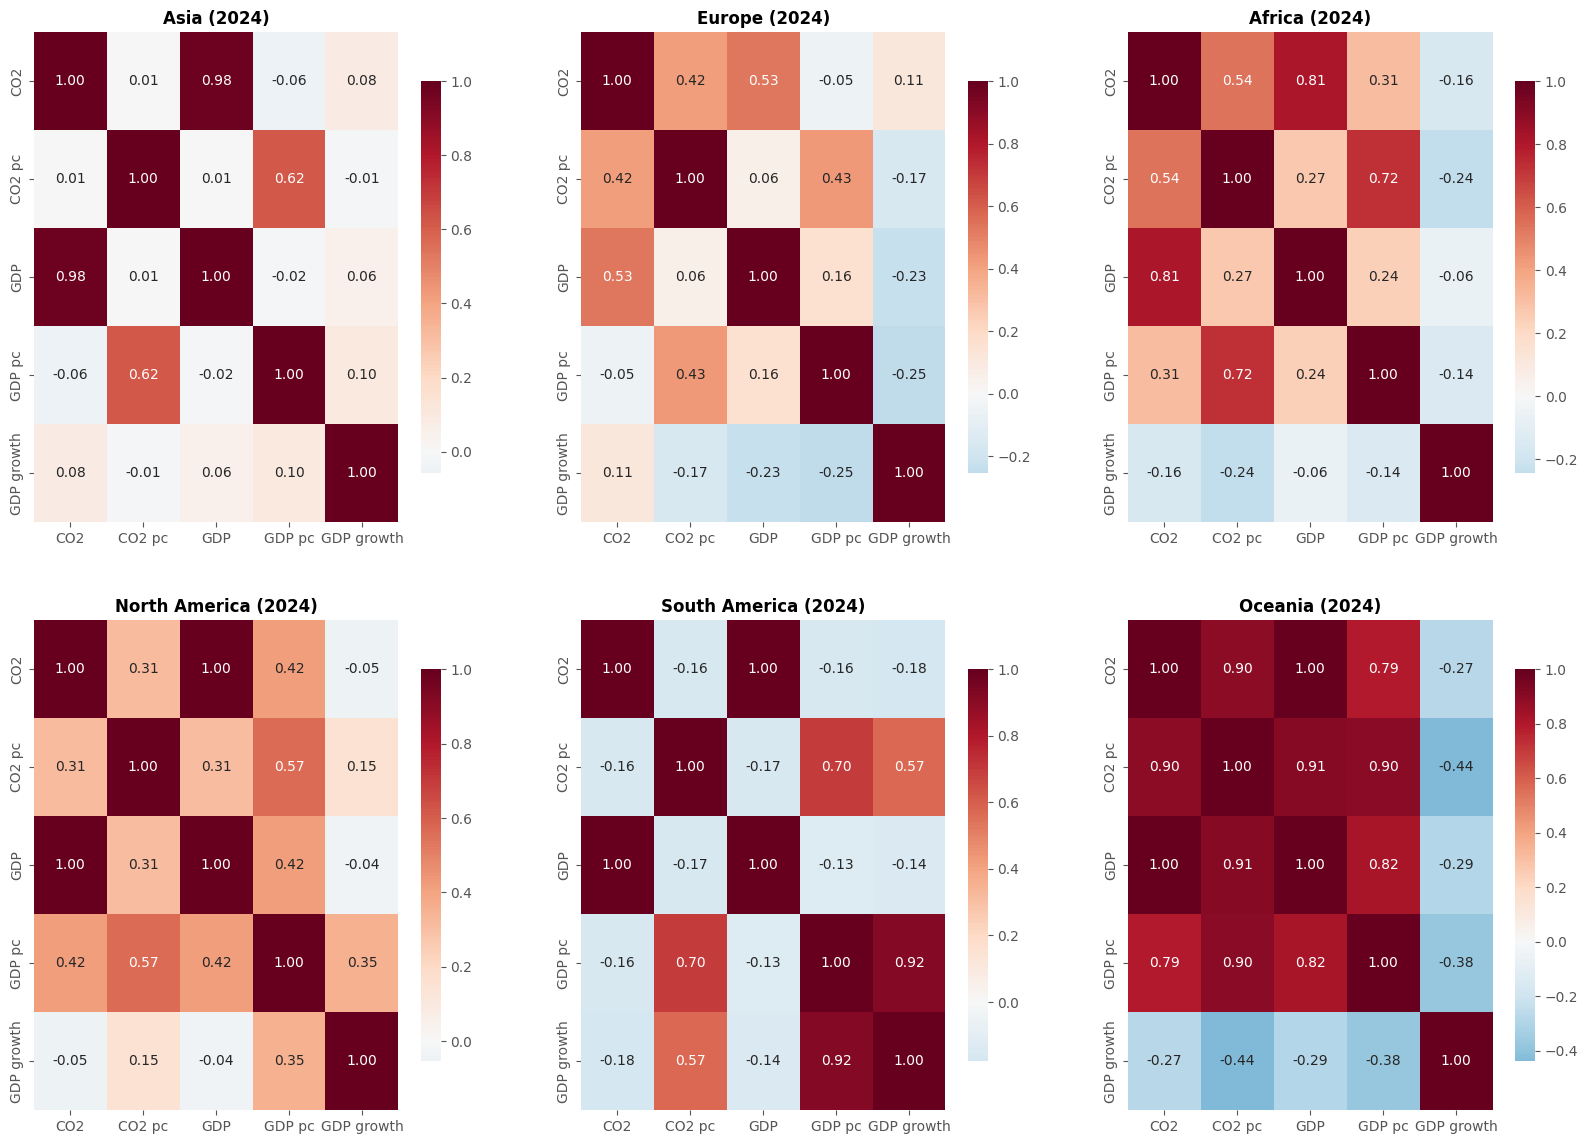

In [9]:
continents = df['Continent'].unique()
continents = [c for c in continents if pd.notna(c)]  # Remove NaN values

numeric_cols = ['Total CO2 emissions', 'CO2 emissions per capita', 
                'GDP', 'GDP per capita', 'GDP growth (annual %)']
short_names = {'Total CO2 emissions': 'CO2', 'CO2 emissions per capita': 'CO2 pc', 
              'GDP': 'GDP', 'GDP per capita': 'GDP pc', 'GDP growth (annual %)': 'GDP growth'}

# Create two main figures
fig_all_years, axes_all_years = plt.subplots(2, 3, figsize=(20, 14))
fig_2024, axes_2024 = plt.subplots(2, 3, figsize=(20, 14))

axes_all_years = axes_all_years.flatten()
axes_2024 = axes_2024.flatten()

for idx, continent in enumerate(continents):
    # All years heatmap
    df_continent = df[df['Continent'] == continent]
    correlation_matrix = df_continent[numeric_cols].corr()
    correlation_matrix.index = [short_names[col] for col in correlation_matrix.index]
    correlation_matrix.columns = [short_names[col] for col in correlation_matrix.columns]
    
    min_year = df_continent['Year'].min()
    max_year = df_continent['Year'].max()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f",
                ax=axes_all_years[idx], cbar_kws={'shrink': 0.8})
    axes_all_years[idx].set_title(f'{continent} ({min_year}-{max_year})', fontsize=12, fontweight='bold')
    
    # 2024 heatmap
    df_continent_2024 = df[(df['Year'] == 2024) & (df['Continent'] == continent)]
    correlation_matrix_2024 = df_continent_2024[numeric_cols].corr()
    correlation_matrix_2024.index = [short_names[col] for col in correlation_matrix_2024.index]
    correlation_matrix_2024.columns = [short_names[col] for col in correlation_matrix_2024.columns]
    
    sns.heatmap(correlation_matrix_2024, annot=True, cmap='RdBu_r', center=0, fmt=".2f",
                ax=axes_2024[idx], cbar_kws={'shrink': 0.8})
                
    axes_2024[idx].set_title(f'{continent} (2024)', fontsize=12, fontweight='bold')

# Hide unused subplots if continents < 6
for idx in range(len(continents), len(axes_all_years)):
    axes_all_years[idx].set_visible(False)
    axes_2024[idx].set_visible(False)

fig_all_years.suptitle('Correlation Heatmaps by Continent (All Years)', fontsize=16, y=0.995)
fig_all_years.subplots_adjust(hspace=0.5, wspace=0.3)
fig_all_years.savefig('../outputs/plots/heatmaps/correlation_heatmap_all_continents_all_years.png', 
                      dpi=300, bbox_inches='tight')
plt.show()

fig_2024.suptitle('Correlation Heatmaps by Continent (2024)', fontsize=16, y=0.995)
fig_2024.subplots_adjust(hspace=0.5, wspace=0.4)
fig_2024.savefig('../outputs/plots/heatmaps/correlation_heatmap_all_continents_2024.png', 
                 dpi=300, bbox_inches='tight')
plt.show()